### Linear Regression the Bayesian Way

**Note that is still work in progress**

This is a simple notebook demonstrating three approaches to fitting Bayesian Linear Regression:

* The Brute Force evaluation of the unnormalized posterior at all positions 
* The MCMC (just for completeness)
    * MCMC by hand
    * MCMC with TensorFlow probabilty
* The Bayes by Backprop approach

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0  
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [3]:
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

In [4]:
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# import tensorflow as tf
# import tensorflow_probability as tfp
# import numpy as np
# sns.reset_defaults()
# #sns.set_style('whitegrid')
# sns.set_context(context='talk',font_scale=0.7)
# %matplotlib inline
# tfd = tfp.distributions
# print("TFB Version", tfp.__version__)
# print("TF  Version", tf.__version__)
# plt.style.use('default') # No background 
# plt.rcParams.update({'font.size': 15}) # Large Fonts

### Creation of data

Creation of some data

$$
    p(y|x) = N(a \cdot x + b, \sigma^2=1) \; \; \text{with } a=1 \text{ and } b=-1
$$  


In [5]:
np.random.seed(2)
num = 4
nbins = 10
bmin=-5;bmax=2
amin=1;amax=6
xmin = -5;xmax = +5;ymin=-40;ymax=40;
nbins_c=30; sigma=3
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,3,num) 

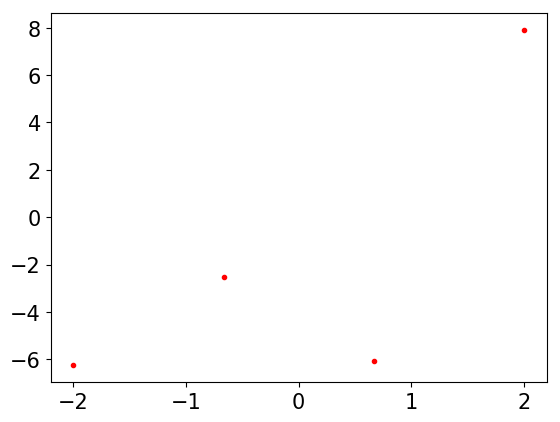

In [6]:
def createData(save=False):
    plt.scatter(x,y, marker='.', color='r')
    #print("x ", x.shape, "  ", y.shape)
    if save:
        d = np.transpose(np.vstack((x[:,0],y)))
        np.savetxt('data_blr_{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e');     
    return (x,y)
x,y = createData()

### Fitting a linear model (Max Likelihood)
First fit a linear model (corresponding to the maximum likelihood approach)

In [7]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml)

Coefficients a_ml:  2.9205102572725816 Coefficients b_ml -1.726712471421449


## Bayesian linear regression
We now assume the following posterior knowlegde 

1. We assume that we know the noise on the data. We can drop this assumption, however, here we want to show the different ways to fit Bayesian models. Estimating $\sigma$ is a bit more complicated, since we cannot assume a Gaussian prior.

2. We assume the following priors on the weight $a \thicksim N(0,1)$ and intercept $b \thicksim N(0,1)$

### Brute Force Bayesian

$$
    P(w|d) \thicksim \frac{P(d|w) P(w)}{P(d)} 
$$

We can calculate $P(d|w) P(w) =: \tt{unnormalized{\_}posterior}$ quite easily. For convenience we calculate the log.

In [8]:
ytensor = y.reshape([len(y),1])
def unnormalized_posterior(w):
    rv_a = tfd.Normal(loc=0., scale=1.) #This is the prior for the slope and
    rv_b = tfd.Normal(loc=0., scale=1.) #intercept.    
    y_prob = tfd.Independent(tfd.Normal(loc=x*w[0]+w[1], scale=1.0), reinterpreted_batch_ndims=1)
    #y_prob = tfd.Normal(loc=x*w[0]+w[1], scale=1.0)
    return (
         tf.reduce_sum(
             rv_a.log_prob(w[0])+ 
             rv_b.log_prob(w[1])+
             #y_prob.log_prob(ytensor)) #Cauased many problems
             tf.reduce_sum(y_prob.log_prob(ytensor))) 
    )

In [50]:
w = tf.Variable([[1.0],[2.0]],dtype=tf.float32)
for e in range(300):
    with tf.GradientTape() as tape: 
        loss = -unnormalized_posterior(w)
        grads = tape.gradient(loss, w)
        w = tf.Variable(w - 0.01*grads)
a_max_post = w[0].numpy()[0]
b_max_post = w[1].numpy()[0]
print("Maximum A-Posterior a", a_max_post, " b ", b_max_post)

Maximum A-Posterior a 2.6251767  b  -1.3813689


In [10]:
ai, bi = np.mgrid[amin:amax:nbins*1j, bmin:bmax:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unpost = np.zeros((nbins*nbins))
for i in range((nbins*nbins)):
    unpost[i] = unnormalized_posterior(tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32))/num
unpost = np.exp(unpost.reshape(ai.shape))
post = unpost / np.sum(unpost) #<-- We normalize

We now evaluate the unnormalized posterior on a $\tt{nbins} \times \tt{nbin}$ grid, ranging from $[-3,+3]$ for the both the intercept and the slope. Outside this range the probability is (nearly) zero and we can use the values to normalize unpost to become a real posterior.

In [11]:
ai.shape, bi.shape, unpost.shape, #ai,bi

((10, 10), (10, 10), (10, 10))

Text(0.5, 1.0, 'Posterior Weight Distribution')

<Figure size 600x600 with 0 Axes>

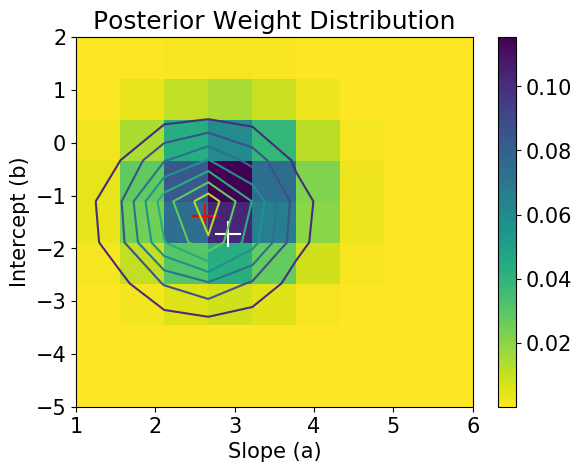

In [12]:
plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(ai, bi, post, cmap=cmap)
plt.contour(ai, bi, post)
fig.colorbar(im, ax=ax0)
plt.scatter(a_ml, b_ml, color='w', marker='+',s=333)
plt.scatter(a_max_post, b_max_post, color='r', marker='+',s=333)
plt.xlabel('Slope (a)')
plt.ylabel('Intercept (b)')
plt.title('Posterior Weight Distribution')

In [13]:
def pre_distribution(a,b):
    """
        Return the predictive distribution p(y|(a,b)) for a, b
    """
    canvas0 = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
    xi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    yi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    for j,x_ in enumerate(np.linspace(xmin, xmax, nbins_c)):
        py = tfd.Normal(loc=a*x_+b,scale=sigma)
        for i,y_ in enumerate(np.linspace(ymin, ymax, nbins_c)):
            xi[i,j] = x_
            yi[i,j] = y_
            #canvas0[nbins_c-i-1,j] = py.prob(y_)
            canvas0[i,j] = py.prob(y_)
    # This part is a bit tricky. The sum over y for a fixed a should be 1. 
    # However, IMHO due to (more than finite) bin width this is not the case
    # We renormalize
    return canvas0/ np.sum(canvas0,axis=0), xi, yi

In [14]:
def toBin(a, amin, amax):
    a = np.clip(a, amin, amax)
    return int(0.99999*(a - amin)/(amax-amin) * nbins)

def getProb(a,b):
    return post[toBin(a,amin,amax),toBin(b,bmin,bmax)]

In [15]:
xmin = -10;xmax = +10;ymin=-40;ymax=40;
nbins_c=30
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
pyx = np.zeros((nbins_c, nbins_c), dtype=np.float32) #A 
for a in np.linspace(amin, amax, nbins): #B
    for b in np.linspace(bmin, bmax, nbins):
        p = getProb(a,b) #C
        pyx += pre_distribution(a,b)[0] * getProb(a,b) 
        if (b == bmin):
            print(p)

1.2902163897209855e-06
8.210415368413966e-06
2.4360622179702274e-05
3.3700121614093835e-05
2.1736698242632977e-05
6.536967979042187e-06
9.165946684803779e-07
5.992363369567705e-08
1.8265804245721295e-09
2.5959777078963402e-11


Text(0.5, 1.0, 'Predictive Distr. (with N(0,1.) piors)')

<Figure size 600x600 with 0 Axes>

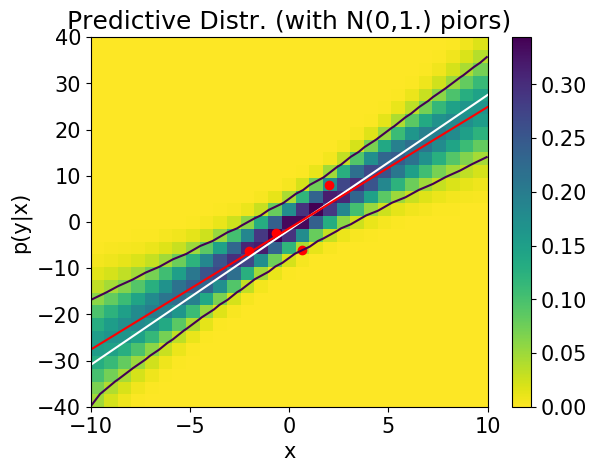

In [16]:
dumm,xi,yi = pre_distribution(a_ml,b_ml)
fig = plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(xi, yi, pyx, cmap=cmap)
plt.contour(xi, yi, pyx,[0.05])
fig.colorbar(im, ax=ax0)
plt.scatter(x,y, marker='o',c='r')

plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='w', alpha = 1)
plt.plot([xmin, xmax], [a_max_post*xmin+b_max_post, a_max_post*xmax+b_max_post], color='r', alpha = 1)

plt.xlabel('x')
plt.ylabel('p(y|x)')
plt.title('Predictive Distr. (with N(0,1.) piors)')

#### Shortcommings of the brute force approach
So we are done. Let's move to networks and fit the 50 million weights. 
Calculating the unnormalized posterior is easy. Done? Wait a moment. In the above example with the two weights we evaluated the unnormalized probability distribution at $\tt{nbins} \times \tt{nbins}$. If we would also fit the sigma parameter that would be $\tt{nbins}^3$ parameters. So a network with 50 million parameters would need $\tt{nbins}^{50 million}$. Let's be satisfied with only $\tt{nbins}=10$. Then we would have $10^{50'000'000}$. If you could do one billion evaluations per second, that would be still take you $10^{50'000'000}/10^9 = 10^{49'999'991}$ seconds. Even for a small network with 100 weights that would take $10^{100}/10^9 = 10^{91}$ seconds. Fun fact go type `10^100 / 10^9 seconds` into [Wolfram Alpha](https://www.wolframalpha.com/input/?i=10%5E100+%2F+10%5E9+seconds). Solution it will take $3.169 \cdot 10^{83}$ years about 10 billion times longer than the age of the univers! [Forget it Ming!](https://getyarn.io/yarn-clip/ecb8c167-324e-4532-9a96-6b0b958fbe52)

This brute force approach does not do the trick for Bayesian Neural Networks. What next? There is an approach called Markov Chain Monte Carlo MCMC for short. It will work for small problems say 10-100 weights but not for large networks. 

### Using MCMC
In the MCMC method you start at a certain value (a and b). Then you step to nearby values (a' and b') if the probability for the nearby value is higher, you accept it. If not you you accept if with the probability $P((a',b')|d)/P((a,b)|d)$. The great thing is that just need the unormalized probability in that case. So we jump from state to state and simply count how often we are in the state XXXXXXTODO.

In MCMC if the prior is wrong, and you don't have any mass at the real values, you are in trouble! 
Therefore use a slope and intercept within the prior. We are lucky in our case. Another solution would be to use a vage prior with a very broad sigma.


The easiest MCMC-algorithm is random walk metropolis. This is included in TensorFlow probability.


In [17]:
#The sampler
metropolis=tfp.mcmc.RandomWalkMetropolis(target_log_prob_fn=unnormalized_posterior,seed=42)

#Does create a chain of samples
states, kernel_results = tfp.mcmc.sample_chain(
        num_results=400,
        current_state = tf.Variable([[5],[-5]],dtype=tf.float32),
        kernel=metropolis)

/usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Text(0, 0.5, 'Sampled values of a / b')

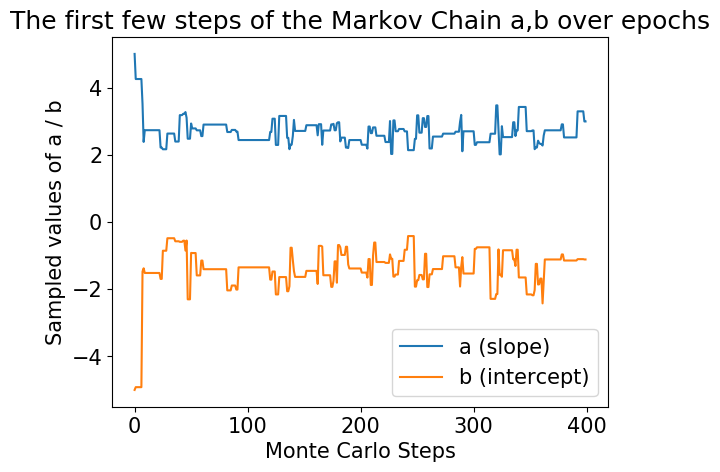

In [18]:
plt.plot(states[:,0])
plt.plot(states[:,1])
plt.legend(('a (slope)','b (intercept)'))
plt.title("The first few steps of the Markov Chain a,b over epochs")
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Sampled values of a / b')

Text(0, 0.5, 'b intercept')

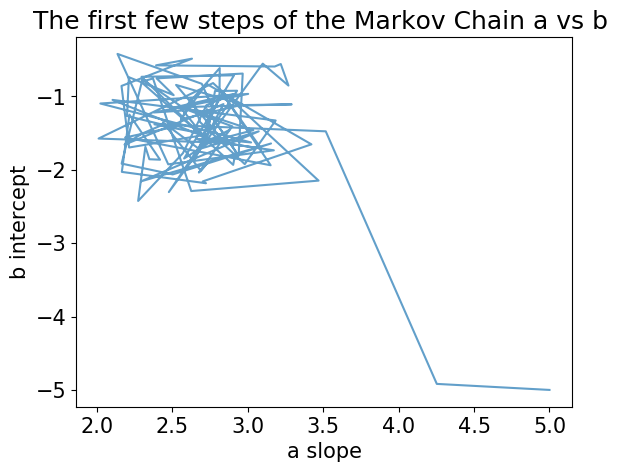

In [19]:
import pandas as pd
df=pd.DataFrame({'xvalues': states[0:400,0,0], 'yvalues': states[0:400,1,0] })
plt.title("The first few steps of the Markov Chain a vs b ")
plt.plot('xvalues', 'yvalues', data=df, alpha=0.7) #third argument, it could be several chains
plt.xlabel('a slope')
plt.ylabel('b intercept')

How often a chain visits a certain value (combination a,b) is proportional to the posterior probability $P((a,b)|d)$ 
You see the chain is often at regions with hight probability. Around $a=1$ and $b=-1$

slope 2.644509792327881  std 0.3121936321258545
inter -1.2933380603790283  std 0.42920976877212524


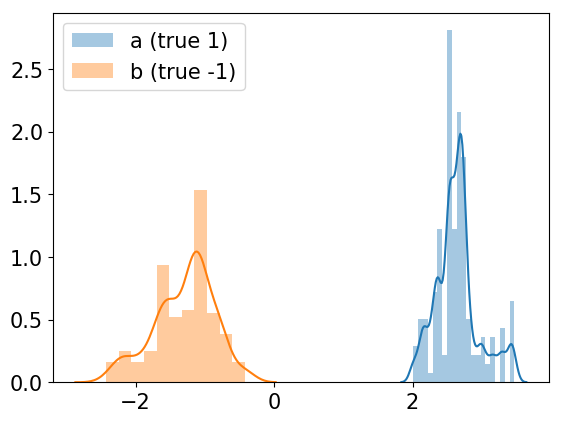

In [20]:
sns.distplot(states[200:,0], norm_hist=True, kde=True)
sns.distplot(states[200:,1], norm_hist=True, kde=True)
plt.legend(('a (true 1)','b (true -1)'))
print("slope {}  std {}".format(np.mean(states[200:,0]), np.std(states[200:,0])))
print("inter {}  std {}".format(np.mean(states[200:,1]), np.std(states[200:,1])))

For a better statistic we want to have more samples, we increase the number of results. To be fast, we compile the calculations into a TensorFlow function.

In [21]:
import time
start = time.time()
w = current_state = tf.Variable([[5],[-5]],dtype=tf.float32)
@tf.function #Much faster, when compiling
def run_chain():
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=20000,
        current_state = w,
        kernel=metropolis)
    return(states, kernel_results)
states, kernel_results = run_chain()
print(time.time() - start, " seconds")

/usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


28.470317840576172  seconds


Actually we have 2-D density and should reflect this fact in the plot. There can be correlations between the variables. Let's look at the covariance matrix.

In [22]:
cov_mcmc = np.cov(np.transpose(states[200:,:,0]))
cov_mcmc

array([[0.09885157, 0.00196046],
       [0.00196046, 0.2015346 ]])

slope 2.622727155685425  std 0.31440669280160355
inter -1.3870124816894531  std 0.44892605476920766


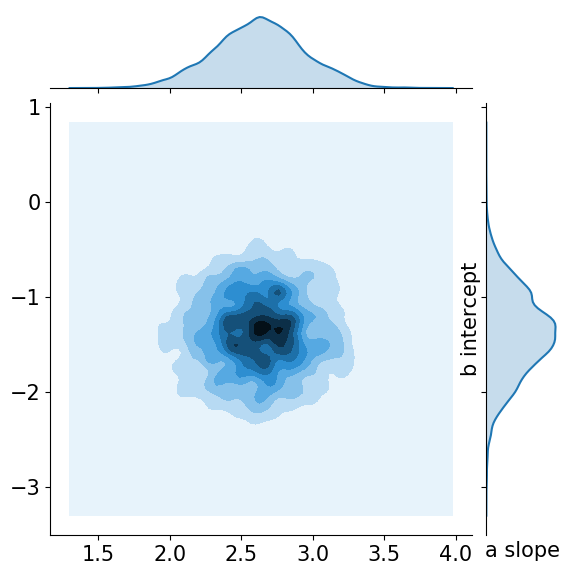

In [23]:
sns.jointplot(x=states[200:,0], y=states[200:,1], kind='kde')

plt.xlabel('a slope')
plt.ylabel('b intercept')
a_locmcmc = np.mean(states[200:,0])
b_locmcmc = np.mean(states[200:,1])
print("slope {}  std {}".format(a_locmcmc, np.sqrt(cov_mcmc[0,0])))
print("inter {}  std {}".format(b_locmcmc, np.sqrt(cov_mcmc[1,1])))

### Comparison

First we compare the MCMC Result, with the brute-force result. In the density plot from the brute force method, we plot the isolines of constant variation. 

In [24]:
#taken from https://scipython.com/book/chapter-7-matplotlib/examples/bmi-data-with-confidence-ellipses/
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


(-5, 2)

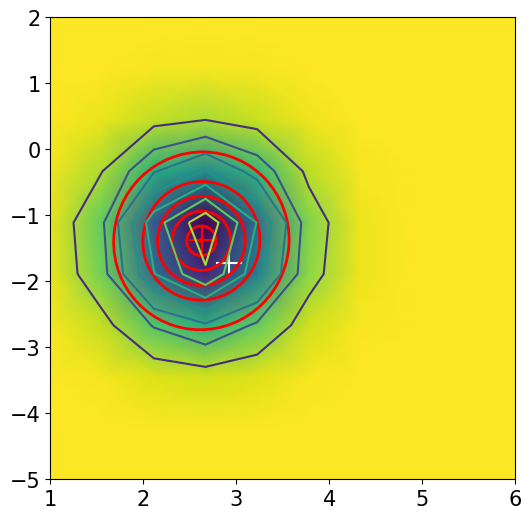

In [25]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.pcolormesh(ai, bi, post, shading='gouraud',cmap="viridis_r")
ax.contour(ai, bi, post, color='green')
for s in (0.05,0.5,1.5,1,2,3):
    e = get_cov_ellipse(cov_mcmc, (a_locmcmc, b_locmcmc), s, fill=False, linewidth=2,color='r')
    ax.add_artist(e)
plt.scatter(a_ml, b_ml, color='w', marker='+',s=333)
plt.scatter(a_max_post, b_max_post, color='r', marker='+',s=333)
ax.set_xlim(amin,amax)
ax.set_ylim(bmin,bmax)

Caption: Comparison of the brute force method and the MCMC simulation. The ML Solution is shown in white.

Since there is no approximation, we get a quite a remarkable agreement. Let's look at the variational approximation.

### MCMC with Edward
**Just for completness** the MCMC definition of the model has been done using the function `unnormalized_posterior`. Alternatively one can specify a model using the Edward Language. 

#### Defining the model using Edward

Here we define the models generative process. Using the Distributions provided in Edward2. The Syntax seems to be:

* input the data value x
* variables with names. These names are later used to feed in the variables from the MCMC runs. **They do matter**

In [26]:
def linear_regression(x):
  """
      features is a list containing []
  """
  D = x.shape[1]      # number of dimensions
  a_ed = ed.Normal(         # normal prior on weights
      loc=tf.zeros([D,1], dtype=tf.float32),
      scale=tf.ones([D,1], dtype=tf.float32),
      name="coeffs")   #<--- The name of these variables is important
  b_ed = ed.Normal(          # normal prior on bias
      loc=tf.zeros([1], dtype=tf.float32), 
      scale=tf.ones([1], dtype=tf.float32),
      name="bias") 
# We have fixed the noise here
#   noise_std = ed.HalfNormal( # half-normal prior on noise std
#       scale=tf.ones([1]),
#       name="noise_std")
  predictions = ed.Normal(   # normally-distributed noise
      loc=tf.matmul(x, a_ed)+b_ed,
      scale=tf.ones([1], dtype=tf.float32),
      name="predictions")
  return predictions

In [27]:
from tensorflow_probability import edward2 as ed
# Joint posterior distribution
log_joint = ed.make_log_joint_fn(linear_regression)

def target_log_prob_fn(coeffs, bias):
  return log_joint(
      x=np.array(x,dtype='float32'),
      coeffs=coeffs, #<-- This has to have the same name as above 
      bias=bias,
      predictions=y.reshape([len(y),1]))

tf.Variable([[5],[-5]],dtype=tf.float32)

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 5.],
       [-5.]], dtype=float32)>

In [28]:
#The sampler
metropolis=tfp.mcmc.RandomWalkMetropolis(target_log_prob_fn=target_log_prob_fn,seed=42)

D = 1
coeffs_size = [D,1]
bias_size = [1]
current_state=[
        tf.zeros(coeffs_size, name='init_coeffs', dtype=tf.float32),
        tf.zeros(bias_size, name='init_bias',dtype=tf.float32)
    ]

#Does create a chain of samples
states_ed, kernel_results_ed = tfp.mcmc.sample_chain(
        num_results=10000,
        current_state =current_state,
        kernel=metropolis)

/usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [29]:
ed_a = states_ed[0][200:,0,0]
ed_b = states_ed[1][200:,0]
ed_cv = np.cov(np.array((ed_a,ed_b))).reshape(-1)

In [30]:
pd.DataFrame({
 'Edward    ':[tf.reduce_mean(ed_a).numpy(),tf.reduce_mean(ed_b).numpy(), ed_cv[0],ed_cv[1],ed_cv[2],ed_cv[3]],  
 'Non-Edward':[a_locmcmc,b_locmcmc, cov_mcmc[0,0],cov_mcmc[0,1],cov_mcmc[1,0],cov_mcmc[1,1]]
 },index=['a','b','cov11','cov12','cov21','cov22']
)

,Edward,Non-Edward
a,2.630131,2.622727
b,-1.386502,-1.387012
cov11,0.100454,0.098852
cov12,-0.001634,0.001960
cov21,-0.001634,0.001960
cov22,0.195689,0.201535


### Variational Method
The Markov Chain Monte Carlo Method is still too slow. One fix is not randomly jump around in the high dimensional space but to be quided. There is many research on that (Hamiltonian, No-UTurn Sample XXXsomebody with knowlegde please add).
Another trick, used especially for Neural Networks is Variational Bayes. 

### Variational inference by hand

We now calculate the variational inference "by hand" i.e. without using Keras layers. 

The Variational Inference involves the calculation of the KL Divergence between.

$$
KL(p(q|\theta) || P(w)) 
$$
We model the posterior with 2 independent Gaussians. 

For Gaussians with $N(0,1)$ priors, we can calculate this as (see Kingma Welling 2013 VAE paper in the appendix)
$$
    KL(q(\mu_1|\sigma_1) || N(0,1)) = -\frac{1}{2}  (1 + log(\sigma^2) - \mu^2 - \sigma^2) 
$$

To check this result we could also use tfd.

In [31]:
mu = 2.
s  = 3.
print(tfd.Normal(2, 3).kl_divergence(tfd.Normal(0, 1)))
-(1. + np.log(s**2) - mu**2 - s**2)/2.

tf.Tensor(4.9013877, shape=(), dtype=float32)


4.90138771133189


We use one vector of size 4 to encode the variational parameters. With the following indices
* 0 Expectation of bias / intercept term
* 1 Rho of bias  / intercept term
* 2 Expectation of slope
* 3 Rho of bias  / intercept term

Foreach Gaussian we model $\mu$ and $\sigma = \tt{softplus(\rho)}$. The softplus ensures that, we do not get negative values for $\sigma$. 

We further imply the reparameterization trick (for backpropagation) and write

$$
 q(b) = N(\mu_b, \sigma_b) = \mu_b + \sigma_b * \epsilon \; \; \epsilon \thicksim N(0,1)  
$$

In [32]:
class Logger():
    """
    Writes out the weights, gradient, and losses. To be used later in e.g. R. 
    """  
    def __init__(self, steps):
        self.steps = steps
        self.X = np.zeros((steps, 12))
        self.header = 'epoch,w0,w1,w2,w3,wg0,wg1,wg2,wg3,loss,loss_kl,loss_mse'
        
    def log(self, step, epoch, w, w_grad, loss, loss_kl, loss_mse):
        self.X[step,0] = epoch
        self.X[step,1:5] = w.numpy()
        self.X[step,5:9] = w_grad.numpy()
        self.X[step,9] = loss.numpy()
        self.X[step,10] = loss_kl.numpy()
        self.X[step,11] = loss_mse.numpy()
        
    def write4r(self, filename):
        np.savetxt(filename, self.X, delimiter=',', header=self.header,comments="",fmt='%.4e');
        
    def getX(self):
        return self.X


In [33]:
def do_var_mc(lr= 0.0001,epochs=1000, w_0=(0,-1.0,0,-1.0)):
    w = tf.Variable(w_0) #We need all in one array 
    # The noise term
    e = tfd.Normal(loc=0., scale=1.)
    logger = Logger(epochs)
    for i in range(epochs):
        with tf.GradientTape() as tape: 
            # The linear regression with the reparameterization trick
            sa = tf.math.softplus(w[3])
            sb = tf.math.softplus(w[1])
            # a*x + b with a and b sampled from the variational approx. of the posterior
            y_hat = (w[2] + e.sample() * sa) * x + w[0] + e.sample()*sb
            loss_mse = tf.reduce_sum(tf.math.square(ytensor - y_hat))
            #KL-Divergence with Gaussian Priors 
            loss_kl = -0.5*(1.0 + tf.math.log(sa*sa) - sa*sa - w[2]*w[2] + tf.math.log(sb*sb) - sb*sb - w[0]*w[0])
            #loss_kl = pa.kl_divergence(a_rv) + pb.kl_divergence(b_rv) #also to MaxLike
            loss = loss_mse + loss_kl
        grads = tape.gradient(loss, w)
        #w = w - 0.0001*grads # Attention: Does not work in eager
        w = tf.Variable(w - lr*grads) # Gradient Descent   
        logger.log(i, i, w, grads, loss, loss_kl, loss_mse)
    return logger

In [34]:
epochs=5000
logger = do_var_mc(lr=2e-3, epochs=epochs, w_0=(3,+1.5,-3,+2.5))

In [35]:
logger.write4r('n3_lr_2e-3_woff2.csv')

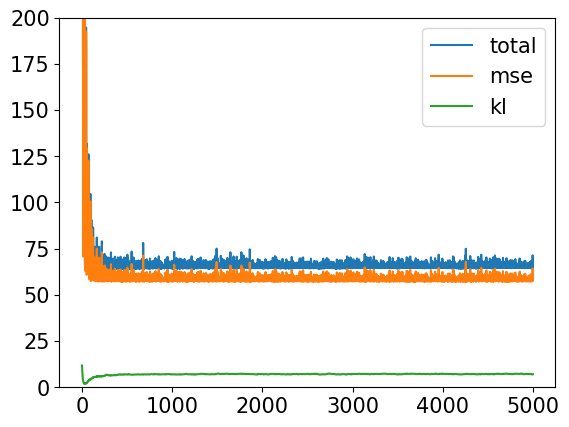

In [54]:
W = logger.getX()
loss_history = W[:,9]
loss_history_mse = W[:,10]
loss_history_kl = W[:,11]
plt.plot(loss_history)
plt.plot(loss_history_kl)
plt.plot(loss_history_mse)
plt.ylim(0,200)
plt.legend(('total', 'mse', 'kl'))
plt.show()
# print('b = ', w[0].numpy(), ' ', tf.math.softplus(w[1]).numpy(), 
#       ' a = ', w[2].numpy(), ' ',  tf.math.softplus(w[3]).numpy())

Note in the figure above, the KL Term does not depend on the number of data points. The MSE loss, however, does. Increasing the number of data point will enlarge the MSE loss but not the KL term. Hence, the importance of the prior decreases. This will sometimes lead to confusion, in TF where the likelihood loss (like the MSE or X-Entropy) is divided by the number of examples. In that case the KL-Divergence term needs also by divided by the number of examples.


### Evolution of the weights

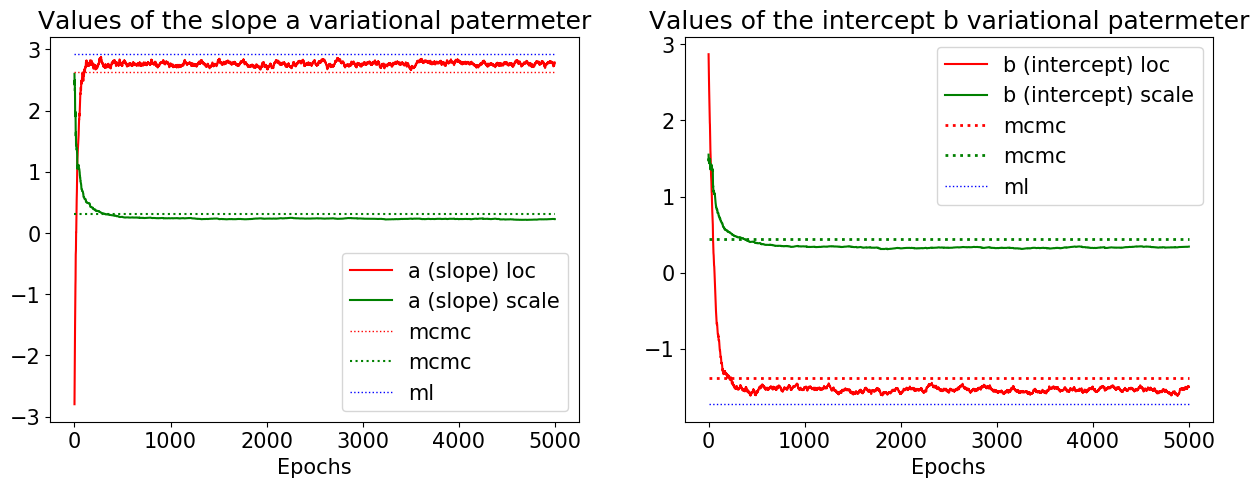

In [37]:
W = logger.getX()
weights = W[:,0:5]
epochs = W.shape[0]
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 5), facecolor='w', edgecolor='k')

#slope a
ax = plt.subplot(121)
ax.plot(weights[:,3], color='r', )
ax.plot(tf.math.softplus(weights[:,4]), color='g')
ax.plot([0, epochs], [a_locmcmc, a_locmcmc], linewidth=1,color='r', linestyle=':')
ax.plot([0, epochs], [np.sqrt(cov_mcmc[0,0]), np.sqrt(cov_mcmc[0,0])], color='g', linestyle=':')
ax.plot([0, epochs],[a_ml, a_ml], linewidth=1,color='b', linestyle=':')
ax.legend(('a (slope) loc', 'a (slope) scale', 'mcmc', 'mcmc', 'ml'))
plt.title("Values of the slope a variational patermeter")
plt.xlabel('Epochs')

#intercept b
ax = plt.subplot(122)
ax.plot(weights[:,1], color='r')
ax.plot(tf.math.softplus(weights[:,2]),color='g')
ax.plot([0, epochs], [b_locmcmc, b_locmcmc], linewidth=2, color='r', linestyle=':')
ax.plot([0, epochs], [np.sqrt(cov_mcmc[1,1]), np.sqrt(cov_mcmc[1,1])], linewidth=2,color='g', linestyle=':')
ax.plot([0, epochs],[b_ml, b_ml], linewidth=1,color='b', linestyle=':')
ax.legend(('b (intercept) loc', 'b (intercept) scale', 'mcmc', 'mcmc','ml'))

plt.title("Values of the intercept b variational patermeter")
plt.xlabel('Epochs')

plt.show()

### Some Animation

Have been done with R using gganimate. The transformation to mp4 with: https://ezgif.com/gif-to-mp4

![Animation](grads_n3_lr_2e-3_woff2.gif)

* Animation on [gif](https://github.com/tensorchiefs/dl_book_playground/blob/master/grads_n3_lr_2e-3_woff2.gif)
as [mp4](https://github.com/tensorchiefs/dl_book_playground/blob/master/grads_n3_lr_2e-3_woff2.mp4)

* Losses [gif](https://github.com/tensorchiefs/dl_book_playground/blob/master/losses_n3_lr_2e-3_woff2.gif)

* Fit [gif](https://github.com/tensorchiefs/dl_book_playground/blob/master/fit_n3_lr_2e-3_woff2)

### Some snapshots

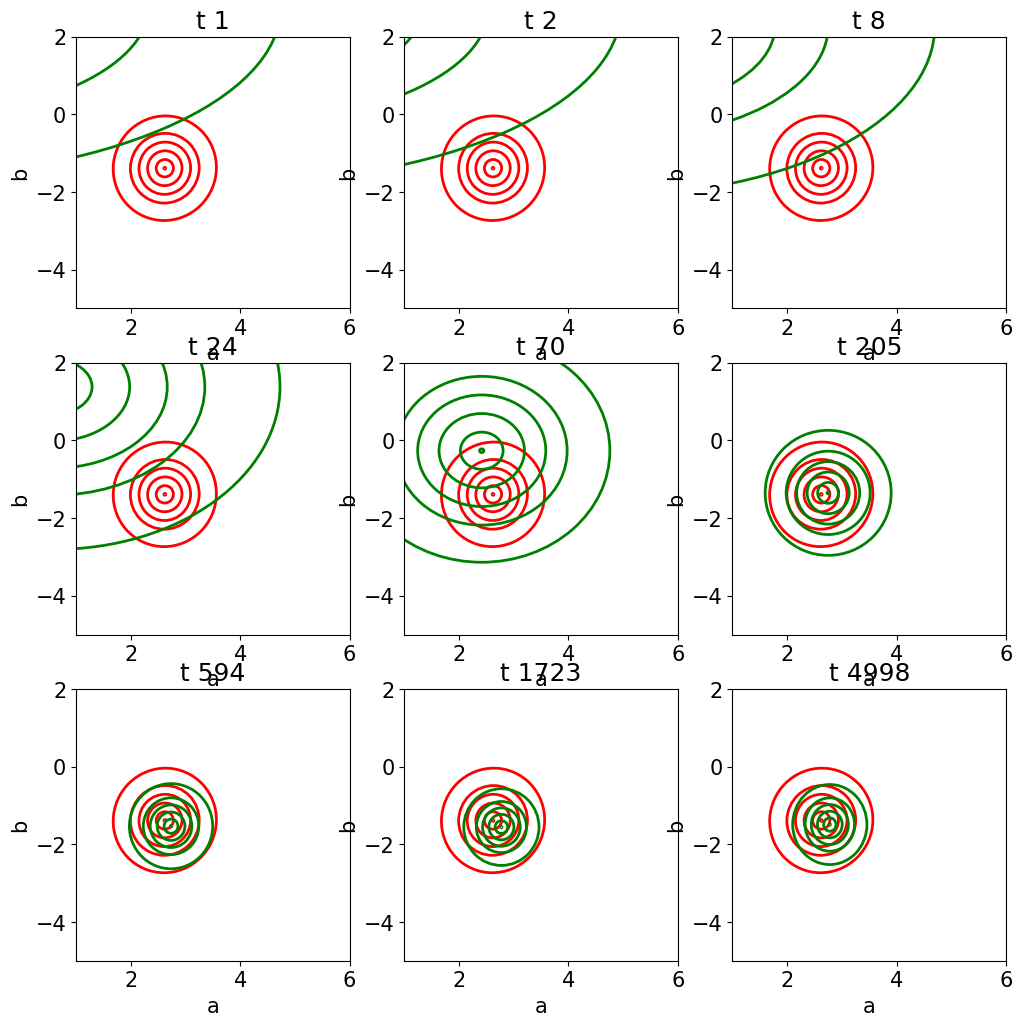

In [38]:
fig = plt.figure(figsize=(12,12))

for i,time in enumerate(np.logspace(0,np.log10(weights.shape[0]-1),9)): 
    ax = fig.add_subplot(3,3,1+i)
    for s in (0.05,0.5,1.5,1,2,3):
        e = get_cov_ellipse(cov_mcmc, (a_locmcmc, b_locmcmc), s, fill=False, linewidth=2,color='r')
        ax.add_artist(e)
    weights = logger.getX()[:,0:5]
    ww2 = tf.math.softplus(weights[int(time),2])
    ww4 = tf.math.softplus(weights[int(time),4])
    cov_var = np.array([ww4**2,0.0,0.0,ww2**2]).reshape((2,2))
    for s in (0.05,0.5,1.5,1,2,3):
        e = get_cov_ellipse(cov_var, (weights[int(time),3], weights[int(time),1]), s, fill=False, linewidth=2,color='g')
        ax.add_artist(e)

    ax.set_xlim(amin,amax)
    ax.set_ylim(bmin,bmax)
    plt.ylabel('b')
    plt.scatter(a_ml, b_ml, color='b', marker='+')
    plt.xlabel('a')
    plt.title('t {}'.format(int(time)))
    plt.scatter(a_ml, b_ml, color='w', marker='+',s=333)

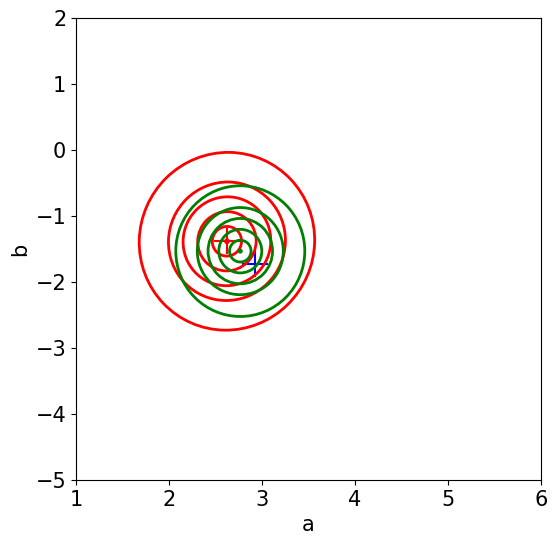

In [39]:
def sp(x):
    return np.log(1 + np.exp(x))**2

def average(weights, num_steps=3000):
    b_m = np.mean([m for m in weights[-num_steps:,1]])
    a_m = np.mean([m for m in weights[-num_steps:,3]])
    c2 =  np.mean([m for m in sp(weights[-num_steps:,2])])
    c4 =  np.mean([m for m in sp(weights[-num_steps:,4])])
    cov_var = np.array([c4,0.0,0.0,c2]).reshape((2,2))
    return (a_m, b_m, cov_var)

a_m, b_m, cov_var = average(logger.getX())

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for s in (0.05,0.5,1.5,1,2,3):
        e = get_cov_ellipse(cov_mcmc, (a_locmcmc, b_locmcmc), s, fill=False, linewidth=2,color='r')
        ax.add_artist(e)
for s in (0.05,0.5,1.5,1,2,3):
        e = get_cov_ellipse(cov_var, (a_m, b_m), s, fill=False, linewidth=2,color='g')
        ax.add_artist(e)
ax.set_xlim(amin,amax)
ax.set_ylim(bmin,bmax)
plt.ylabel('b')
plt.scatter(a_ml, b_ml, color='b', marker='+',s=333)
plt.scatter(a_max_post, b_max_post, color='r', marker='+',s=333)
plt.xlabel('a')
plt.show()

In [40]:
# to animate: https://towardsdatascience.com/how-to-create-animated-graphs-in-python-bb619cc2dec1

### Comparing with TF 


Text(0, 0.5, 'Total loss')

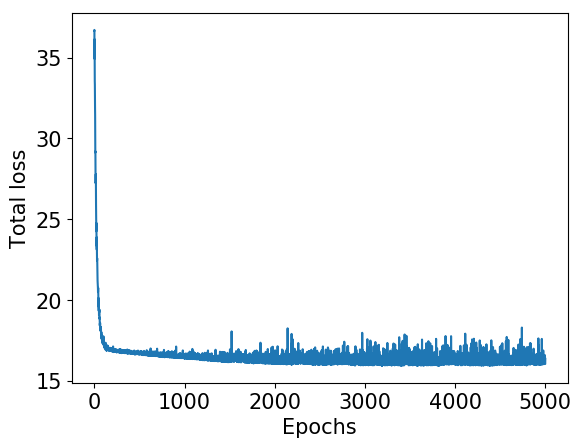

In [41]:
# Rescaling divergence, see above comment
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0)
# In the default implementation the var approximation of the bias is a constant. Here we need a gaussain.

model = tf.keras.Sequential([
    tfp.layers.DenseReparameterization(1,
                                       kernel_divergence_fn=kernel_divergence_fn,
                                       bias_divergence_fn=kernel_divergence_fn, #A
                                       bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,#A
                                       bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn()#A
                                       )
])
sgd = tf.keras.optimizers.SGD(lr=.005)
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
hist = model.fit(x, y, epochs=5000, batch_size=num, verbose=False)
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Total loss')

# A note that keras usually does no prior on the weights, we do this to be able to compare with hand-crafted version

In [42]:
# print("Loss handwritten ", np.min((loss_history[-100:] / num)), 
#       "TF ", np.min(hist.history['loss'][-100:]))
w = model.get_weights()
pd.DataFrame({
    'VI TF ':[w[0][0,0], sp(w[1][[0]])[0,0],w[2][0], sp(w[3][[0]])[0]], 
    'VI Manual ': [a_m, cov_var[0,0], b_m, cov_var[1,1]], 
    'MaxLike':[a_ml[0], '-', b_ml, '-'], 
    'MCMC':[a_locmcmc, cov_mcmc[0,0], b_locmcmc, cov_mcmc[1,1]]},
    index=['a_loc','a_var','b_loc','b_var']
)

,MCMC,MaxLike,VI Manual,VI TF
a_loc,2.622727,2.92051,2.766249,2.763025
a_var,0.098852,-,0.053433,0.051023
b_loc,-1.387012,-1.72671,-1.536393,-1.555493
b_var,0.201535,-,0.108948,0.115092


##  Let's look into details

**This part is just for completness** It shows how to extract values during model fitting. 

We now fit some epochs and record the variational parameters while fitting, using Keras's callback mechanism. We also use unusual start values to see something happening.

In [43]:
epochs = 5000
weights = np.zeros((epochs,5))
def myLogger(epoch, logs):
    w = model.get_weights()
    #Names of the weights via [weight.name for layer in model.layers for weight in layer.weights]
    #From https://stackoverflow.com/questions/40444083/weights-by-name-in-keras
    a_loc = w[0].flatten() #kernel_posterior_loc
    a_sca = tf.math.softplus(w[1].flatten()) #kernel_posterior_untransformed_scale see https://github.com/tensorflow/probability/issues/258
    b_loc = w[2].flatten() #Same for bias
    b_sca = tf.math.softplus(w[3].flatten())
    #print(b_sca)
    weights[epoch] = np.asarray((epoch, a_loc, a_sca, b_loc, b_sca))
    if (epoch < 3):
        print(weights[epoch])
    
batch_print_callback = tf.keras.callbacks.LambdaCallback(on_epoch_begin=myLogger)

inputs = tf.keras.layers.Input(shape=(x.shape[1],))

# We set the posterior by hand to make some noise
kernel_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(
    loc_initializer=tf.compat.v1.initializers.random_normal(mean=-1.,stddev=0.1), #Will go to -> 1
    untransformed_scale_initializer=tf.compat.v1.initializers.random_normal(mean=1., stddev=0.00001),
    is_singular=False
)

bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn( #make some noise
    loc_initializer=tf.compat.v1.initializers.random_normal(mean=2.,stddev=0.1), #Will go to --> -1
    untransformed_scale_initializer=tf.compat.v1.initializers.random_normal(mean=1., stddev=0.00001),
    is_singular=False)


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0)

out = tfp.layers.DenseReparameterization(1,
                                         bias_posterior_fn=bias_posterior_fn,
                                         kernel_posterior_fn=kernel_posterior_fn,
                                         kernel_divergence_fn=kernel_divergence_fn,
                                         bias_divergence_fn=bias_divergence_fn,
                                         bias_prior_fn=tfp.layers.default_multivariate_normal_fn
                                        )(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=out)
sgd = tf.keras.optimizers.SGD(lr=.001)
#sgd = tf.keras.optimizers.Adam(lr=.001)
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
hist = model.fit(x, y, batch_size=num, callbacks=[batch_print_callback],epochs=epochs, verbose=False)

[ 0.         -1.00599265  1.3132664   1.92461634  1.31326091]
[ 1.         -0.99927855  1.31970286  1.91639924  1.31250525]
[ 2.         -0.97867399  1.31416655  1.90897679  1.31291628]


In [44]:
W = logger.getX()
loss_history = W[:,9]
print("Loss handwritten ", np.min((loss_history[-100:] / num)), 
      "TF ", np.min(hist.history['loss'][-100:]))
w = model.get_weights()
w

Loss handwritten  16.085430145263672 TF  15.931581497192383


[array([[2.756793]], dtype=float32),
 array([[-1.2396493]], dtype=float32),
 array([-1.5563546], dtype=float32),
 array([-0.7894934], dtype=float32)]

Text(0, 0.5, 'Loss ??? ELBO? Check')

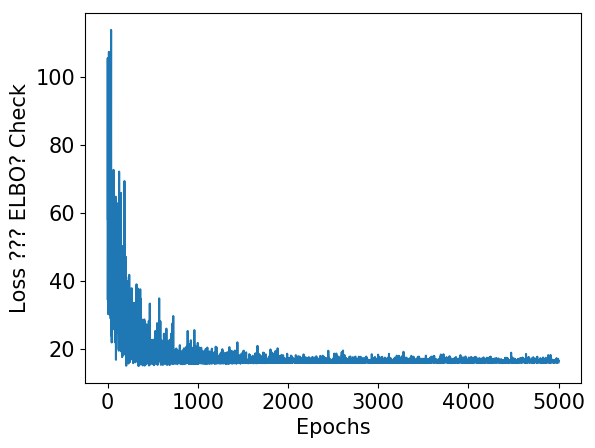

In [52]:
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss ??? ELBO? Check')

In [46]:
preds = [model.predict([0]) for i in range(1000)] #We average over the stochastic outsputs
final_b = np.mean(preds) #We average over the 
print(final_b)
at1 = np.mean([model.predict([1]) for i in range(1000)])
#print(at1)
print("Slope ", at1 - final_b)
model.get_weights()

-1.5742817
Slope  2.7811713


[array([[2.756793]], dtype=float32),
 array([[-1.2396493]], dtype=float32),
 array([-1.5563546], dtype=float32),
 array([-0.7894934], dtype=float32)]

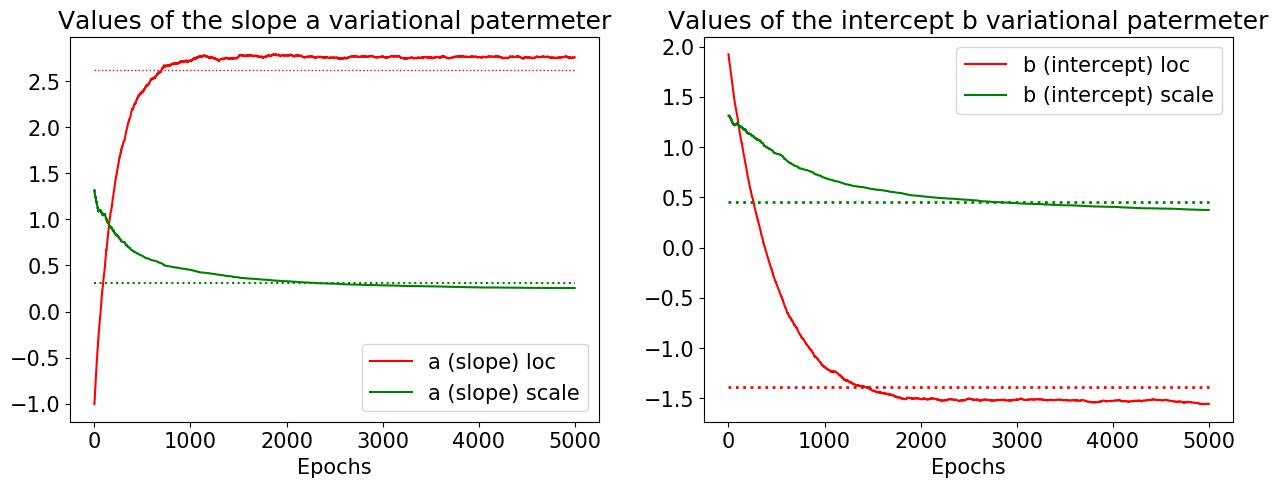

In [47]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 5), facecolor='w', edgecolor='k')

ax = plt.subplot(121)
ax.plot(weights[:,1], color='r')
ax.plot(weights[:,2], color='g')
ax.plot([0, epochs], [a_locmcmc, a_locmcmc], linewidth=1,color='r', linestyle=':')
ax.plot([0, epochs], [np.sqrt(cov_mcmc[0,0]), np.sqrt(cov_mcmc[0,0])], color='g', linestyle=':')
ax.legend(('a (slope) loc', 'a (slope) scale'))
plt.title("Values of the slope a variational patermeter")
plt.xlabel('Epochs')

ax = plt.subplot(122)
ax.plot(weights[:,3], color='r')
ax.plot(weights[:,4],color='g')
ax.plot([0, epochs], [b_locmcmc, b_locmcmc], linewidth=2, color='r', linestyle=':')
ax.plot([0, epochs], [np.sqrt(cov_mcmc[1,1]), np.sqrt(cov_mcmc[1,1])], linewidth=2,color='g', linestyle=':')
ax.legend(('b (intercept) loc', 'b (intercept) scale'))

plt.title("Values of the intercept b variational patermeter")
plt.xlabel('Epochs')

plt.show()

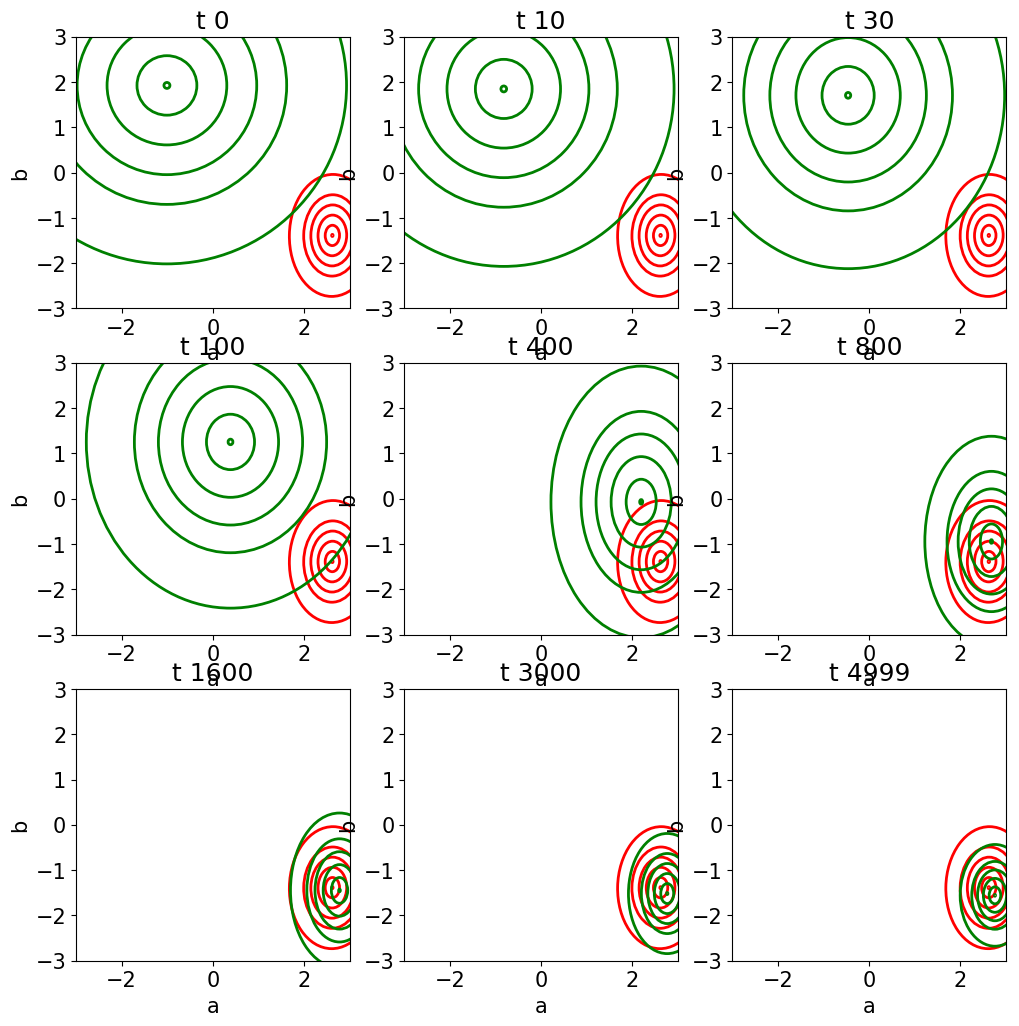

In [51]:
fig = plt.figure(figsize=(12,12))

for i,time in enumerate((0,10,30,100,400,800,1600,3000, 4999)): 
    ax = fig.add_subplot(3,3,1+i)
    for s in (0.05,0.5,1.5,1,2,3):
        e = get_cov_ellipse(cov_mcmc, (a_locmcmc, b_locmcmc), s, fill=False, linewidth=2,color='r')
        ax.add_artist(e)

    w = weights[time,:] #(epoch, a_loc, a_sca, b_loc, b_sca)
    cov_var = np.array([w[2]**2,0.0,0.0,w[4]**2]).reshape((2,2))
    for s in (0.05,0.5,1.5,1,2,3):
        e = get_cov_ellipse(cov_var, (w[1], w[3]), s, fill=False, linewidth=2,color='g')
        ax.add_artist(e)

    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    plt.ylabel('b')
    plt.xlabel('a')
    plt.title('t {}'.format(time))

In [49]:
# to animate: https://towardsdatascience.com/how-to-create-animated-graphs-in-python-bb619cc2dec1